In [1]:
import os

import matplotlib.pyplot as plt
import gensim
from gensim import models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk

from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, BatchNormalization

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(2018)

In [2]:
notebook_dir = os.getcwd()
rel_path = '../../data/complete_data/testimonies_cleaned_spy_tnx.csv'

df=pd.read_csv(os.path.join(notebook_dir, rel_path), parse_dates=['date'])

In [3]:
df['contents'] = df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
df

,date,contents,speaker,title,cleaned content,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+7,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,^TNX: d-1,^TNX: d+0
0,1996-06-26,It is a pleasure to appear before this Subcomm...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices,"['SECTION', 'SECTION', 'SECTION', 'SECTION', '...",42.397709,42.110374,42.407631,42.556236,42.922832,...,41.416790,41.585213,41.753658,40.911457,40.941177,39.732361,39.831451,40.307041,6.896,6.896
1,1996-07-17,I am pleased to appear before the Committee on...,"Herbert A. Biern, Deputy Associate Director, D...","""Prime bank"" schemes","['SECTION', 'SECTION', 'SECTION', 'SECTION', '...",39.831451,40.307041,40.861912,40.564682,40.267422,...,40.406143,39.960251,40.346680,40.643932,41.317699,42.209446,41.961739,42.090553,6.808,6.821
2,1996-07-18,Testimony of Chairman Alan Greenspan The Feder...,Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report,"['Testimony', 'Chairman', 'Alan', 'Greenspan',...",40.307041,40.861912,40.564682,40.267422,39.752174,...,39.960251,40.346680,40.643932,41.317699,42.209446,41.961739,42.090553,42.199535,6.821,6.709
3,1996-07-24,I am pleased to appear before this Subcommitte...,Governor Janet L. Yellen,Trends in consumer lending,"['SECTION', 'SECTION', 'SECTION', 'SECTION', '...",39.752174,39.831451,40.188141,40.406143,39.960251,...,42.209446,41.961739,42.090553,42.199535,42.130188,41.991463,42.298615,41.961739,6.795,6.864
4,1996-07-26,I appreciate this opportunity to appear before...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations,"['SECTION', 'SECTION', 'SECTION', 'SECTION', '...",40.188141,40.406143,39.960251,40.346680,40.643932,...,42.090553,42.199535,42.130188,41.991463,42.298615,41.961739,42.110374,42.031086,6.851,6.837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2021-09-28,"The Federal Reserve, the central bank of the U...",Chair Jerome H. Powell,Coronavirus and CARES Act,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",441.090363,432.201569,432.929016,427.637634,432.719757,...,437.124268,436.327057,433.168182,432.101929,433.656464,440.950836,444.309021,445.624420,1.484,1.534
450,2021-11-30,"The Federal Reserve, the central bank of the U...",Chair Jerome H. Powell,Coronavirus and CARES Act,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",462.973480,453.965118,448.922821,455.798676,451.832611,...,464.717346,469.091949,464.936584,461.737793,468.952454,464.816986,459.869995,454.980011,1.530,1.443
451,2022-01-11,"The Federal Reserve, the central bank of the U...",Chair Jerome H. Powell,Nomination hearing,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",465.510010,469.750000,471.019989,464.529999,464.720001,...,437.980011,439.839996,434.470001,433.380005,431.239990,441.950012,449.910004,452.950012,1.780,1.746
452,2022-01-13,"The Federal Reserve, the central bank of the U...",Governor Lael Brainard,Nomination hearing,"['Federal', 'Reserve', 'central', 'bank', 'Uni...",471.019989,464.529999,464.720001,456.489990,451.750000,...,434.470001,433.380005,431.239990,441.950012,449.910004,452.950012,457.350006,446.600006,1.725,1.711


# Preprocessing

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phzeller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
stemmer = SnowballStemmer('english')

In [6]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
processed_docs = df['contents'].map(preprocess)

In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abil
1 abl
2 access
3 account
4 achiev
5 action
6 activ
7 addit
8 address
9 adequaci
10 advertis


In [9]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [11]:
# bow_doc_43 = bow_corpus[43]

# for i in range(len(bow_doc_43)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_43[i][0], 
#                                                      dictionary[bow_doc_43[i][0]], 
#                                                      bow_doc_43[i][1]))

In [12]:

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# LDA using bag of words

In [13]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [14]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"mortgag" + 0.009*"budget" + 0.008*"spend" + 0.006*"propos" + 0.006*"equiti" + 0.006*"debt" + 0.005*"fiscal" + 0.005*"deriv" + 0.004*"project" + 0.004*"incom"
Topic: 1 
Words: 0.021*"inflat" + 0.011*"labor" + 0.008*"employ" + 0.007*"longer" + 0.007*"pace" + 0.007*"spend" + 0.006*"fomc" + 0.006*"outlook" + 0.006*"household" + 0.006*"unemploy"
Topic: 2 
Words: 0.020*"small" + 0.017*"educ" + 0.008*"survey" + 0.008*"disclosur" + 0.007*"deposit" + 0.006*"lend" + 0.006*"depositori" + 0.004*"offer" + 0.004*"propos" + 0.004*"student"
Topic: 3 
Words: 0.022*"mortgag" + 0.012*"disclosur" + 0.012*"card" + 0.010*"lend" + 0.008*"borrow" + 0.008*"foreclosur" + 0.008*"creditor" + 0.007*"propos" + 0.007*"score" + 0.007*"examin"
Topic: 4 
Words: 0.014*"deposit" + 0.013*"currenc" + 0.007*"premium" + 0.007*"depositori" + 0.006*"fdic" + 0.006*"dollar" + 0.005*"propos" + 0.005*"treasuri" + 0.005*"lend" + 0.005*"small"
Topic: 5 
Words: 0.011*"deposit" + 0.010*"depositori" + 0.010*"pro

# LDA using TF-IDF

In [15]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [16]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"budget" + 0.008*"social" + 0.007*"retir" + 0.006*"fiscal" + 0.005*"surplus" + 0.004*"deficit" + 0.004*"medicar" + 0.004*"launder" + 0.004*"inflat" + 0.004*"spend"
Topic: 1 Word: 0.006*"basel" + 0.005*"dodd" + 0.005*"supervisori" + 0.005*"frank" + 0.005*"examin" + 0.004*"mortgag" + 0.004*"lend" + 0.004*"crisi" + 0.004*"communiti" + 0.004*"guidanc"
Topic: 2 Word: 0.006*"inflat" + 0.004*"fomc" + 0.003*"energi" + 0.003*"municip" + 0.003*"mortgag" + 0.003*"outlook" + 0.002*"labor" + 0.002*"nomin" + 0.002*"fiscal" + 0.002*"investor"
Topic: 3 Word: 0.005*"foreclosur" + 0.004*"mortgag" + 0.004*"text" + 0.003*"currenc" + 0.003*"lehman" + 0.003*"card" + 0.003*"releas" + 0.002*"examin" + 0.002*"fraud" + 0.002*"inflat"
Topic: 4 Word: 0.009*"facil" + 0.006*"pandem" + 0.004*"deriv" + 0.004*"municip" + 0.004*"bond" + 0.003*"treasuri" + 0.003*"launder" + 0.003*"section" + 0.003*"inflat" + 0.003*"dealer"
Topic: 5 Word: 0.004*"mortgag" + 0.004*"card" + 0.003*"deposit" + 0.003*"chec

# Doc2vec

In [17]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(df.contents))

In [18]:
#session crashed when i ran this, even when I had a GPU connected it didnt seem to use the GPU
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec(train_corpus, vector_size=200, window=3, min_count=1, workers=4)

In [19]:
def getVecs(model_name, corpus, size):
    vecs = [np.array(model_name[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)
train_vecs_dm = getVecs(model, train_corpus, 200)

# Predictions on SPY changes


In [20]:
def pct_change_from_day_0(announcement):
    pct_change= (announcement['SPY: d+7']/announcement['SPY: d-1'])-1
    if pct_change>0:
        return 'up'
    else:
        return 'down'

In [21]:
pct_change_from_day_0(df.iloc[141])

'down'

In [22]:
df['+7change']=df.apply(pct_change_from_day_0,axis=1)

In [23]:
df['+7change'].value_counts()

up      260
down    194
Name: +7change, dtype: int64

In [24]:
labels=df['+7change'].to_numpy()
labels_onehot=pd.get_dummies(labels).values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_vecs_dm,labels_onehot,train_size=0.9)
print (len(X_train),len(X_test),len(y_train),len(y_test))

408 46 408 46


In [26]:
X_train_m, X_val, y_train_m, y_val = train_test_split(X_train,y_train,train_size=0.9)
print (len(X_train_m),len(X_val),len(y_train_m),len(y_val))

367 41 367 41


In [27]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history=model.fit(X_train_m, y_train_m,validation_data=(X_val,y_val), epochs = 30, batch_size = 100)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-14 19:06:20.565258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 19:06:20.565406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2022-03-14 19:06:21.475830: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 19:06:22.873765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:23.174021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:24.882363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:26.517591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:27.875397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.5095

2022-03-14 19:06:30.917278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:31.004262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 19:06:31.235975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 10s 957ms/step - loss: 0.2855 - accuracy: 0.5095 - val_loss: 0.2491 - val_accuracy: 0.6341
Epoch 2/30
4/4 [==============================] - 0s 106ms/step - loss: 0.2748 - accuracy: 0.5695 - val_loss: 0.2480 - val_accuracy: 0.6341
Epoch 3/30
4/4 [==============================] - 0s 101ms/step - loss: 0.2634 - accuracy: 0.5777 - val_loss: 0.2469 - val_accuracy: 0.6341
Epoch 4/30
4/4 [==============================] - 0s 99ms/step - loss: 0.2703 - accuracy: 0.5586 - val_loss: 0.2462 - val_accuracy: 0.6341
Epoch 5/30
4/4 [==============================] - 0s 96ms/step - loss: 0.2608 - accuracy: 0.5640 - val_loss: 0.2455 - val_accuracy: 0.6341
Epoch 6/30
4/4 [==============================] - 0s 97ms/step - loss: 0.2551 - accuracy: 0.5613 - val_loss: 0.2450 - val_accuracy: 0.6341
Epoch 7/30
4/4 [==============================] - 0s 100ms/step - loss: 0.2676 - accuracy: 0.5695 - val_loss: 0.2444 - val_accuracy: 0.6341
Epoch 8/30
4/4 [=================

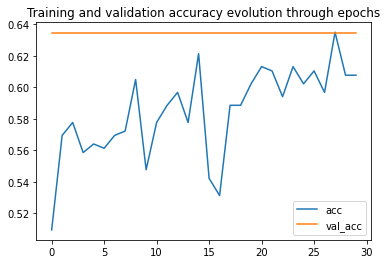

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy evolution through epochs')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

In [29]:
model.evaluate(X_train,y_train)

13/13 [==============================] - 1s 76ms/step - loss: 0.2479 - accuracy: 0.5613


[0.24786287546157837, 0.561274528503418]

In [30]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 521ms/step - loss: 0.2332 - accuracy: 0.6739


[0.23323358595371246, 0.6739130616188049]